# Exploring conformational space of selected macrocycles - "M1", Part 2


In this notebook we present the geometry optimization of the selected conformers with the DFT methods. The generation and the pre-selection of conformers were discussed in another notebook ([link](http://nbviewer.jupyter.org/github/gosiao/icho-notebooks/blob/master/conformers_m1.ipynb)).

In particular, here we will show:

* the optimized geometries of M1 conformers, aligned

* the M1 conformers selected after the removal of duplicates, aligned; the resulting set will constitute the total pool of conformers (100%);

* for the lowest-energy conformer, we will evaluate:

    * the role of dispersion corrections (comparison of PBE and B97D exchange-correlation functionals),
    
    * basis set effects (comparison of 6-31Gd and cc-pVTZ basis set; extrapolation to the complete basis set (CBS) limit),
    
    * the method deficiency (comparison of DFT and MP2 methods),

* in the total pool of conformers we will identify:

    * the global minimum,
    
    * the local minima,
    
    * the saddle points (optionally),
    
* for all the conformers in the total pool of conformers, we will evaluate the free energy corrections (Gibbs free enthalpy calculations for T=298.15K) and determine their population (Boltzmann weights);


All the DFT calculations are performed with the Gaussian 09 software.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import glob
import py3Dmol

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)
import os,time
print( time.asctime())

2016.09.4
Tue May 23 09:39:13 2017


In [3]:
# Functions used in this notebook:
def grep_energies_from_csvfile(fcsv):
    energies = {}
    with open(fcsv,'r') as f:
        lines = f.readlines()
        for line in lines:
            words = line.split()
            name = words[0].rsplit("_", 5)[0]
            energies[name] = float(words[1])
    return energies

def find_duplicates(rms_sorted, energy, rms_thresh, print_msg):
    i = 0
    to_be_deleted = []
    while i < len(rms_sorted):
        j = i + 1
        while j < len(rms_sorted):
            if rms_sorted[i][0] in to_be_deleted:
                i = i + 1
                j = j + 1
            elif rms_sorted[j][0] in to_be_deleted:
                j = j + 1
            else:
                rms1 = rms_sorted[i][1]
                rms2 = rms_sorted[j][1]
                if (rms2 - rms1) < rms_thresh:
                    if energy[rms_sorted[i][0]] < energy[rms_sorted[j][0]]:
                        to_be_deleted.append(rms_sorted[j][0])
                    else:
                        to_be_deleted.append(rms_sorted[i][0])
                else:
                    break
        i = i + 1
    if to_be_deleted and print_msg:
        print("Conformers which will be deleted:")    
        print(to_be_deleted)
    return to_be_deleted

def get_moldict_from_inplist(inplist):
    moldict = {}
    for i, inp in enumerate(inplist):
        mol = Chem.MolFromMolFile(inp)
        name = os.path.basename(os.path.splitext(inp)[0]).rsplit("_", 5)[0]
        model = "_".join(os.path.basename(os.path.splitext(inp)[0]).rsplit("_", 2)[1:])
        moldict[name] = mol
    return moldict

def check_freq(method, freq_inp_list):
    negative_freq_dict = {}
    for inp in freq_inp_list:
        count = 0
        with open(inp, "r") as f:
            lines = f.readlines()
            for line in lines:
                freq = line.split().strip()[1]
                print(freq)
                if float(freq) < 0.0:
                    count += 1
            if count > 0:
                negative_freq_list[os.path.basename(os.path.splitext(inp)[0]).rsplit("_", 5)[0]] = count
    if negative_freq_dict:
        return negative_freq_dict
    else:
        print("{}: all harmonic frequencies are positive".format(method))


def align_and_show(moldict):
    
    for key, mol in moldict.items():    
        core_mol = mol.GetSubstructMatch(Chem.MolFromSmiles(core_smiles))
        AllChem.AlignMol(mol,m1_crystal,atomMap=list(zip(core_mol,core_m1)))
    
    p = py3Dmol.view(width=400,height=400)
    for key, mol in moldict.items(): 
        mb = Chem.MolToMolBlock(mol)
        p.addModel(mb,'sdf')
    p.setStyle({'stick':{'radius':'0.15'}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p 

In [4]:
# decide what is the "core" - a part of molecule, which we wish to be most aligned (rmsd-wise) among all the structures
smiles = 'O=C1NCCNC(=O)c2nc(C(=O)NCCNC(=O)c3nc1ccc3)ccc2'
core_smiles = 'n1ccccc1'

m1 = Chem.AddHs(Chem.MolFromSmiles(smiles))
core_m1 = m1.GetSubstructMatch(Chem.MolFromSmiles(core_smiles))

templ_m1 = Chem.SDMolSupplier('/home/gosia/work/work_on_gitlab/icho/calcs/m1/balloon/m1_crystal.sdf')
m1_crystal = templ_m1[0]

## Geometry optimization in Gaussian 09 software

### Computational setup and workflow

Since there are only few pre-selected conformer candidates, we have used two DFT models for the geometry optimization and harmonic frequency calculations:

* DFT without dispersion corrections (PBE) and with 6-31G(d) basis set ("pbe_631");

* DFT with dispersion corrections (B97D) and with 6-31G(d) basis set ("b97d_631");

For both models we will compare the optimized geometries and energies and remove the duplicates.





For the lowest-energy conformer we will evaluate the error due to the computational model by performing the calculations with:

* MP2 method and 6-31G(d) basis set ("mp2_631")
* MP2 method and cc-pVTZ basis set ("mp2_ccpvtz")
* MP2 method and the complete basis set limit (?)
    


For all the conformers we will do Gibbs free enthalpy calculations and determine the population of conformers.

### Results

#### Comparison of DFT results with and without dispesion corrections

In [5]:
inps_gaussian_pbe_631gd = glob.glob('/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/*pbe_631gd.sdf')
mol_gaussian_pbe_631gd = get_moldict_from_inplist(inps_gaussian_pbe_631gd)

inps_gaussian_b97d_631gd = glob.glob('/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/*b97d_631gd.sdf')
mol_gaussian_b97d_631gd = get_moldict_from_inplist(inps_gaussian_b97d_631gd)

#p = align_and_show(mol_m1_gaussian_pbe_631gd) 
#p.show()

In [6]:
f_pbe_631gd = "/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/energy_pbe_631gd.csv"
energy_pbe_631gd = grep_energies_from_csvfile(f_pbe_631gd)

f_b97d_631gd = "/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/energy_b97d_631gd.csv"
energy_b97d_631gd = grep_energies_from_csvfile(f_b97d_631gd)

rms_pbe_631gd = {}
rms_b97d_631gd = {}

for key, mol in mol_gaussian_pbe_631gd.items():
    rms_pbe_631gd[key] = AllChem.GetBestRMS(Chem.RemoveHs(mol),Chem.RemoveHs(m1_crystal))
for key, mol in mol_gaussian_b97d_631gd.items():
    rms_b97d_631gd[key] = AllChem.GetBestRMS(Chem.RemoveHs(mol),Chem.RemoveHs(m1_crystal))    

In [7]:
#Having a set of DFT-optimized conformers, 
# we will analyze the root-mean-square distance between them (RMSD) and their energy in order to remove duplicates.

rms_thresh = 0.05
rms_sorted_pbe_631gd = sorted(rms_pbe_631gd.items(), key=lambda x: x[1])
rms_sorted_b97d_631gd = sorted(rms_b97d_631gd.items(), key=lambda x: x[1])

# now compare RMS of each pair, if the structures are too similar then delete the one with the higher energy
to_be_deleted_pbe_631gd = find_duplicates(rms_sorted_pbe_631gd, energy_pbe_631gd, rms_thresh, False)
to_be_deleted_b97d_631gd = find_duplicates(rms_sorted_b97d_631gd, energy_b97d_631gd, rms_thresh, False)

for mol in to_be_deleted_pbe_631gd:
    del mol_gaussian_pbe_631gd[mol]
    del energy_pbe_631gd[mol]
    del rms_pbe_631gd[mol]
    
for mol in to_be_deleted_b97d_631gd:
    del mol_gaussian_b97d_631gd[mol]
    del energy_b97d_631gd[mol]
    del rms_b97d_631gd[mol]

# print the names and energies of remaining conformers, sorted by energies:
print("Selected conformers sorted by energies [a.u.], pbe_631gd: ")
energy_pbe_631gd_sorted = sorted(energy_pbe_631gd.items(), key=lambda x: x[1])
for i, p in enumerate(energy_pbe_631gd_sorted):
    print("{0:<5} {1:20}  {2:20} ".format(i+1, p[0], p[1]))

print("\n")
print("Selected conformers sorted by energies [a.u.], b97d_631gd: ")
energy_b97d_631gd_sorted = sorted(energy_b97d_631gd.items(), key=lambda x: x[1])
for i, p in enumerate(energy_b97d_631gd_sorted):
    print("{0:<5} {1:20}  {2:20} ".format(i+1, p[0], p[1]))

Selected conformers sorted by energies [a.u.], pbe_631gd: 
1     m1_b_sdf_3                  -1324.91571522 
2     m1_rdkit_smi_10             -1324.87644552 
3     m1_rdkit_smi_20             -1324.87344873 
4     m1_rdkit_smi_16             -1324.86930427 
5     m1_rdkit_smi_32             -1324.86197522 


Selected conformers sorted by energies [a.u.], b97d_631gd: 
1     m1_b_sdf_3                  -1325.34337037 
2     m1_b_sdf_0                  -1325.34066663 
3     m1_rdkit_smi_10             -1325.31935223 
4     m1_rdkit_smi_51             -1325.30901709 
5     m1_rdkit_smi_16                -1325.30782 
6     m1_rdkit_smi_32             -1325.29926582 
7     m1_rdkit_sdf_26             -1325.29594008 


All these conformers are local minima:

In [8]:
f_freq_gaussian_pbe_631gd = glob.glob('/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/freq*pbe_631gd.csv')
freq_gaussian_pbe_631gd = check_freq("pbe_631gd", f_freq_gaussian_pbe_631gd)

pbe_631gd: all harmonic frequencies are positive


In [9]:
f_freq_gaussian_b97d_631gd = glob.glob('/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/freq*pbe_631gd.csv')
freq_gaussian_b97d_631gd = check_freq("b97d_631gd", f_freq_gaussian_b97d_631gd)

b97d_631gd: all harmonic frequencies are positive


The aligned structures of selected conformers obtained with PBE and B97D and 6-31G(d) basis set are presented below:

In [10]:
%%html
<table>
  <tr>
    <td id="pbe_631gd" ></td>
    <td id="b97d_631gd"  ></td>
  <tr>
    <td> pbe_631gd </td>
    <td> b97d_631gd  </td>  
  </tr>
</table>

,
pbe_631gd,b97d_631gd


In [11]:
for key, mol in mol_gaussian_pbe_631gd.items():
    core_mol = mol.GetSubstructMatch(Chem.MolFromSmiles(core_smiles))
    AllChem.AlignMol(mol,m1_crystal,atomMap=list(zip(core_mol,core_m1)))
    
p1 = py3Dmol.view(width=400,height=400)
for key, mol in mol_gaussian_pbe_631gd.items():
    mb = Chem.MolToMolBlock(mol)
    p1.addModel(mb,'sdf')
p1.setStyle({'stick':{'radius':'0.15'}})
p1.setBackgroundColor('0xeeeeee')
p1.zoomTo()
p1.insert("pbe_631gd")

In [12]:
for key, mol in mol_gaussian_b97d_631gd.items():
    core_mol = mol.GetSubstructMatch(Chem.MolFromSmiles(core_smiles))
    AllChem.AlignMol(mol,m1_crystal,atomMap=list(zip(core_mol,core_m1))) 
    
p2 = py3Dmol.view(width=400,height=400)
for key, mol in mol_gaussian_b97d_631gd.items():
    mb = Chem.MolToMolBlock(mol)
    p2.addModel(mb,'sdf')
p2.setStyle({'stick':{'radius':'0.15'}})
p2.setBackgroundColor('0xeeeeee')
p2.zoomTo()
p2.insert("b97d_631gd")    

We will work with conformers optimized with B97D/6-31G(d) model.

In [13]:
# write selected conformers to file:
with open("/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/list_selected_conformers_b97d_631gd", "w") as f:
    for key, mol in mol_gaussian_b97d_631gd.items():
        f.write(key+"\n")

#### The evaluation of model deficiencies - MP2 calculations and basis set effects

Additional calculations were performed for the conformer of the lowest energy - **"m1_b_sdf_3"**. 

For **"m1_b_sdf_3"** we have additionally done (starting with "b97d_631gd" geometry):

* DFT calculations (PBE, B97D) with cc-pVTZ basis set
* MP2 calculations with 6-31GD and cc-pVTZ basis sets

Results (energies) are presented in the table below and the aligned structures are shown on the picture below:

| method | basis set | energy | color |
|--------|-----------|--------|-------|
| PBE  | 6-31G(d)    | -1324.91571522 | 
| PBE  | cc-pVDZ     | energy |
| PBE  | cc-pVTZ     | energy |
| B97D | 6-31G(d)    | -1325.34337037 |
| B97D | cc-pVDZ     |  |
| B97D | cc-pVTZ     | -1325.79875137 |
| MP2  | 6-31G(d)    | -1318.33634104 |
| MP2  | cc-pVDZ     | -1318.45792807 |
| MP2  | cc-pVTZ     | running |

In [14]:
key="m1_b_sdf_3"
geomdir="/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/optimized_geometries_frequencies_from_outputs/"
geoms_lowest_energy = [
    geomdir+key+"_gaussian_optimized_geometry_pbe_631gd.sdf",
    geomdir+key+"_gaussian_optimized_geometry_pbe_ccpvdz.sdf",
    geomdir+key+"_gaussian_optimized_geometry_pbe_ccpvtz.sdf",    
    geomdir+key+"_gaussian_optimized_geometry_b97d_631gd.sdf",
    geomdir+key+"_gaussian_optimized_geometry_b97d_ccpvdz.sdf",
    geomdir+key+"_gaussian_optimized_geometry_b97d_ccpvtz.sdf",    
    geomdir+key+"_gaussian_optimized_geometry_mp2_631gd.sdf",
    geomdir+key+"_gaussian_optimized_geometry_mp2_ccpvdz.sdf",
    geomdir+key+"_gaussian_optimized_geometry_mp2_ccpvtz.sdf"
]

#### Gibbs free energy corrections

Calculated for the selected conformers with **B97D/6-31G(d)** model - only for local minima.

In [28]:
final_results = "/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
final_data    = pd.read_csv(final_results, 
                            skiprows=18, 
                            usecols=[0,5,6,7,8,9,10],
                            delimiter=r"\s+")
final_data

,#Mol,E1-E1(min)[kcal/mol],E2-E2(min)[kcal/mol],E3-E3(min)[kcal/mol],E4-E4(min)[kcal/mol],Boltzmann_weight,Mol_fraction
0,m1_b_sdf_3,0.000000,0.000000,0.000000,0.000000,1.000000,0.142874
1,m1_b_sdf_0,1.362950,1.451429,1.451429,2.447287,0.999984,0.142872
2,m1_rdkit_smi_10,15.151842,14.835577,14.835577,18.207185,0.999879,0.142857
3,m1_rdkit_smi_51,21.314611,21.310846,21.310846,23.058460,0.999846,0.142853
4,m1_rdkit_smi_16,22.411498,22.298546,22.298546,24.544402,0.999837,0.142851
5,m1_rdkit_smi_32,26.800926,27.136016,27.136016,28.170779,0.999812,0.142848
6,m1_rdkit_sdf_26,29.319749,29.443368,29.443368,31.214827,0.999792,0.142845


In [26]:
def plot_line(data, xmin, xmax):
    for i, v in enumerate(data):
        if i == 0:
            ax.hlines(v, xmin, xmax, linestyle='-', color='r', linewidth=1.5)
        else:
            ax.hlines(v, xmin, xmax, linestyle='-', linewidth=1)


def set_style():
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

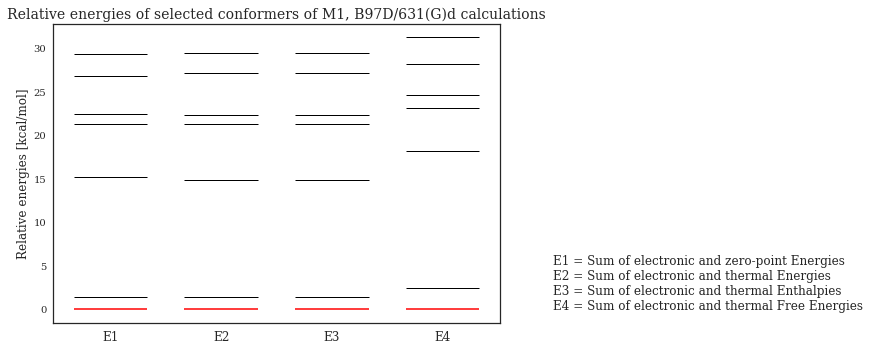

In [29]:
set_style()
fig, ax = plt.subplots()

ax.set_title("Relative energies of selected conformers of M1, B97D/631(G)d calculations", fontsize=14)
ax.set_ylabel("Relative energies [kcal/mol]", fontsize=12)
ax.set_xticks([0.0, 1.5, 3.0, 4.5])
ax.set_xticklabels(["E1", "E2", "E3", "E4"], fontsize=12)

plot_line(final_data["E1-E1(min)[kcal/mol]"], -0.5, 0.5)
plot_line(final_data["E2-E2(min)[kcal/mol]"],  1.0, 2.0)
plot_line(final_data["E3-E3(min)[kcal/mol]"],  2.5, 3.5)
plot_line(final_data["E4-E4(min)[kcal/mol]"],  4.0, 5.0)

ax.text(6, 0,
"E1 = Sum of electronic and zero-point Energies\n\
E2 = Sum of electronic and thermal Energies\n\
E3 = Sum of electronic and thermal Enthalpies\n\
E4 = Sum of electronic and thermal Free Energies")